<div style="text-align: left">
[<img src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="800px">](http://www.datascience-paris-saclay.fr)
</div>

# [RAMP](https://www.ramp.studio/problems/mars_craters) on Mars craters detection

_Alexandre Boucaud (CDS), Joris van den Bossche (CDS), Balazs Kegl (CDS), Frédéric Schmidt (GEOPS), Anthony Lagain (GEOPS)_

1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
3. [Workflow](#Workflow)
4. [Evaluation](#Scoring)
5. [Local testing/exploration](#Local-testing)
6. [Submission](#Submitting-to-ramp.studio)

## Introduction

Impact craters in planetary science are used to date planetary surfaces, to characterize surface processes and to study the upper crust of terrestrial bodies in our Solar System (Melosh, 1989). Thanks to the Martian crater morphology, a wide amount of information could be deduced on the geological history of Mars, as for example the evolution of the surface erosion rate, the presence of liquid water in the past, the volcanic episodes or the volatiles layer in the subsurface (Carr & Head, 2010). These studies are widely facilitated by the availability of reference crater databases. 

Surveying impact craters is therefore an important task which traditionally has been achieved by means of visual inspection of images. The enormous number of craters smaller than one kilometer in diameter, present on high resolution images, makes visual counting of such craters impractical. In order to overcome this problem, several algorithms have been developed to automatically detect impact structures on planetary images (Bandeira et al., 2007 ; Martins et al., 2009). Nevertheless, these methods allow to detect only 70-80 % of craters (Urbach & Stepinski, 2009).

### The prediction task

This challenge proposes to design the best algorithm to detect crater position and size starting from the most complete Martian crater database containing 384 584 verified impact structures larger than one kilometer of diameter (Lagain et al. 2017). We give to the users a subset of this large dataset in order to test and calibrate their algorithms. 

<img src="https://github.com/ramp-kits/mars_craters/raw/master/img/craters_sample.png" width="70%">
<div style="text-align: center">Example of THEMIS reprojected data</div>


We provide THEMIS nightime dataset (Christensen et al., 2003)
already projected to avoid distortion, sampled at various scales and positions in form 224x224 pixels images. Using an appropriate metric, we will compare the true solution to the estimation. The goal is to provide detection of more than 90% (crater center and diameter) with a minimum number of wrong detection.

### References

1. Bandeira, L.; Saraiva, J. & Pina, P., Impact Crater Recognition on Mars Based on a Probability Volume Created by Template Matching, IEEE Transactions on Geoscience and Remote Sensing, Institute of Electrical and Electronics Engineers (IEEE), 2007, 45, 4008-4015 

2. Carr, M. H. and Head, J. W. III. (2010) Geologic history of Mars. Earth and Planetary Science Letters, 294, 185-203.

3. Christensen, P. R.; Bandfield, J. L.; Bell, J. F.; Gorelick, N.; Hamilton, V. E.; Ivanov, A.; Jakosky, B. M.; Kieffer, H. H.; Lane, M. D.; Malin, M. C.; McConnochie, T.; McEwen, A. S.; McSween, H. Y.; Mehall, G. L.; Moersch, J. E.; Nealson, K. H.; Rice, J. W.; Richardson, M. I.; Ruff, S. W.; Smith, M. D.; Titus, T. N. & Wyatt, M. B., Morphology and Composition of the Surface of Mars: Mars Odyssey THEMIS Results, Science, 2003, 300, 2056-2061 

4. Lagain, A., Marmo, C., Delaa, O., Bouley, S., Baratoux, D., Costard, F. et al. (2017) Martian crater database: 1. Reviewing and adapting to surface ages measurement. Submission to the Journal of Geophysical Research planned to November 2017.

5. Martins, R.; Pina, P.; Marques, J.S & Silveira, M., Crater Detection by a Boosting Approach, IEEE Geoscience and Remote Sensing Letters, Institute of Electrical and Electronics Engineers (IEEE), 2009, 6, 127-131

6. Melosh, H. J. (1989) Impact cratering: a geologic process. Oxford University Press.

7. Urbach, E. and Stepinski, T. (2009) Automatic detection of sub-km craters in high resolution planetary images. Planetary and Space Science, 57, 880-887.

## Preprocessing

### From raw data to local quadrangles

The full THEMIS map of Mars has been saved in a cylindrical projection.    Raw visualization of the full map is thus quite difficult.

<img src="img/full_image.png" width="80%">
<div style="text-align: center">Raw THEMIS data</div>

In order to correct for the distortions and recover the circularity of the craters, the map has to be reprojected locally. For that, we use a partitions known as _quadrangles_. 140 quadrangles are used to cover the whole Mars surface from which we selected some (the colored quadrangles) for this exercice.

<img src="img/train_test_quadrangles.png" width="95%">
<div style="text-align: center">
Longitude vs latitude quadrangle division in the raw THEMIS projection.<br/>
Challenge datasets have been constructed using random patches from these quadrangles.<br/>
Numbers indicate quadrangle IDs and colors refer to the train/test and public/private distinction.
</div>

We use the boundaries of the quadrangle to extract the relevant pixels from the raw THEMIS map (above). Here we choose the quadrangle #77, close to the equator, and thus only slightly distorted.

<img src="img/quad_77_original_small.png" width="80%">
<div style="text-align: center">Quadrangle 77</div>

Then we reproject the pixels to the local stereographic projection in order to correct for the distortions. The result can be seen below.

<img src="img/quad_77_localstereo_small.png" width="80%">
<div style="text-align: center">Quadrangle 77 reprojected</div>

For illustration, we use the crater database to project the labeled craters per category on the reprojected map.

<img src="img/quad_77_local_craters_small.png" width="80%">
<div style="text-align: center">Quadrangle 77 reprojected with labelled craters</div>

### From quadrangles to input data

After selecting a common **shape for the input** of image processing models **224x224**, we start from the reprojected quadrangles and decide to create the patches from a tiling with overlap to cover the craters falling on the edges. The tiling is also performed on downsampled versions of the quadrangles, until all craters can be detected for all sizes of craters present.
With the current set up, the **craters** contained in every image **have radii** that span the range **of 5 to 28 pixels**.

With no further do, let's have a look at the data.

### Required dependencies and downloads

#### Installation of libraries and `ramp-workflow`

To get this notebook running and test your models locally using the `ramp_test_submission`, we recommend that you use the Python distribution from [Anaconda](https://www.anaconda.com/download/) or [Miniconda](https://conda.io/miniconda.html). 

In [1]:
# !conda env create -f environment.yml   # use the environment.yml file to create the 'mars-craters' env
# !source activate mars-craters          # activate the virtual environment

**OR** if you have Python already installed but are **not using Anaconda**, you'll want to use `pip` 

In [2]:
# !pip install -r requirements.txt

#### Download script (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.

There are ~700Mb of images.

In [3]:
# !python download_data.py

### The input data

In [4]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
import rampwf as rw

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Circle
%matplotlib inline

In [6]:
X_train = np.load('data/data_train.npy', mmap_mode='r')

print("The training data is made of {} images of {}x{} pixels".format(
    *X_train.shape))

n_img = len(X_train)

The training data is made of 9000 images of 224x224 pixels


Here we display 3 randomly select images. You can play around with the values.

In [11]:
idx_list = [30, 3470, 7030]

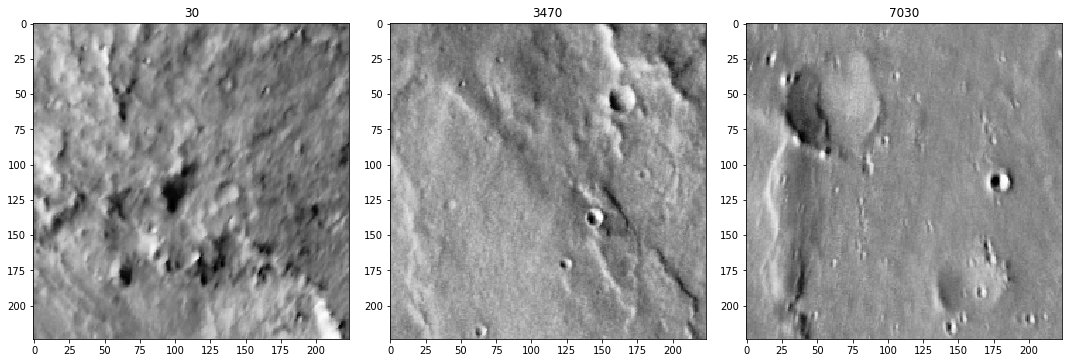

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_list):
    axes[i].imshow(X_train[idx], cmap='Greys_r')
    axes[i].set_title('%d' % idx)
fig.tight_layout()

Most images have some craters but we only label a crater if their diameter is superior to 10 pixels.

In [13]:
y_train = pd.read_csv('data/labels_train.csv')

In [14]:
y_train.head()

,i,row_p,col_p,radius_p
0,0,154.0,51.0,15.75
1,2,46.0,47.0,6.70
2,2,85.0,176.0,5.15
3,2,21.0,156.0,8.50
4,2,150.0,95.0,10.60


The labels consist of a `pandas.DataFrame` containing the list of craters. For each craters, the columns are
- `id`: index of the image it belongs to
- `row_p`, `col_p` : pixel position
- `radius_p` : pixel radius

Let's visualize some.

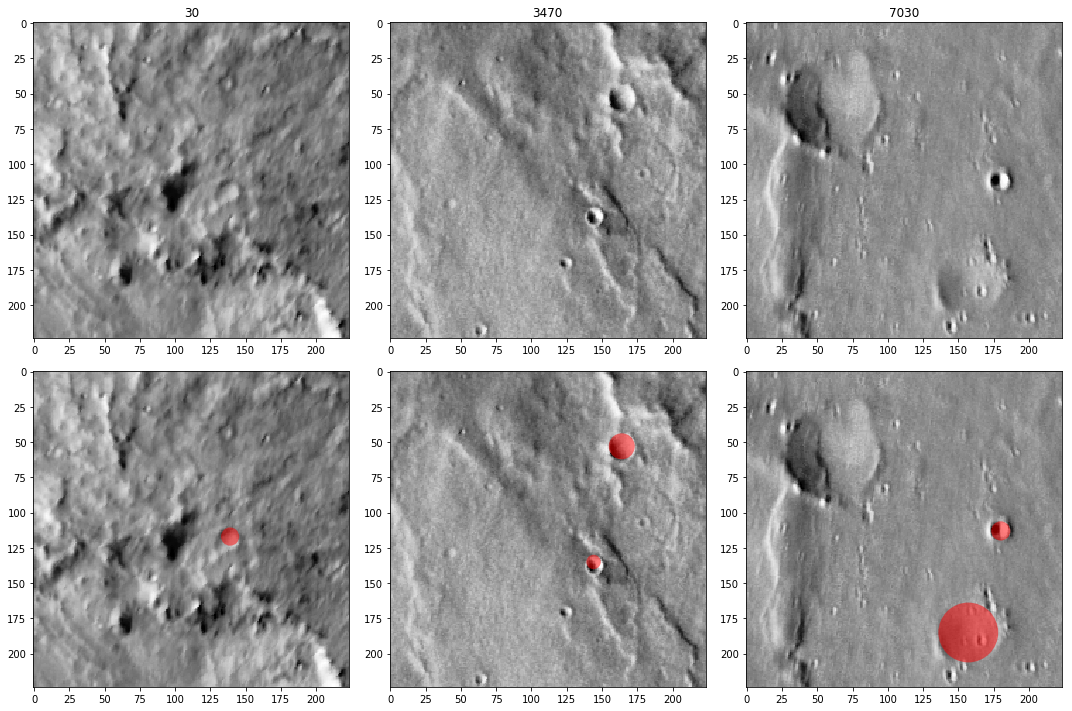

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, idx in enumerate(idx_list):
    img = X_train[idx]
    lab = y_train[y_train['i'] == idx][['row_p', 'col_p', 'radius_p']].values
    # First row images only
    axes[0, i].imshow(img, cmap='Greys_r')
    axes[0, i].set_title('%d' % idx)
    # Second row, labels overlaid on the image
    axes[1, i].imshow(img, cmap='Greys_r')
    if lab.size != 0:
        for y, x, radius in lab:
            crater = Circle((x, y), radius, color='r', ec=None, alpha=0.5)
            axes[1, i].add_patch(crater)
fig.tight_layout()

### Label distribution

#### Individual craters

In [17]:
print("There are {} labeled craters in the training set.".format(y_train.size))

There are 38344 labeled craters in the training set.


#### Lots of "empty" images

In [20]:
n_img_withcraters = y_train['i'].unique().size

print("There are labeled craters in only {:.1%} of the images.".format(
    n_img_withcraters / n_img))

There are labeled craters in only 51.0% of the images.


Text(0.5,1,'Crater radius frequency for the training data')

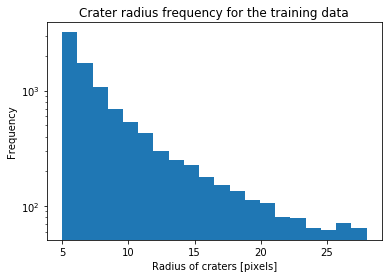

In [21]:
y_train.radius_p.plot(kind='hist', bins=20, log=True)
plt.xlabel('Radius of craters [pixels]')
plt.title('Crater radius frequency for the training data')

## The pipeline

<img src="img/workflow.svg" width="70%">

For submitting at the [RAMP site](http://ramp.studio), you will have to write an `ObjectDetector` class in a file named `object_detector.py` that will handle the training and prediction .

### Object detector

A dummy object detector which detects a single crater in the middle of each patch.

In [23]:
%load submissions/starting_kit/object_detector.py

Format of the data it receives:

In [24]:
import problem

In [25]:
X, y = problem.get_train_data()

In [26]:
X.shape

(9000, 224, 224)

A single image patch:

In [27]:
X[0].shape

(224, 224)

The corresponding ground thruth data for that patch consists of a list of tuples (x, y, radius):

In [28]:
y[0]

[(154.0, 51.0, 15.75)]

In [29]:
y[2]

[(46.0, 47.0, 6.7000000000000002),
 (85.0, 176.0, 5.1500000000000004),
 (21.0, 156.0, 8.5),
 (150.0, 95.0, 10.6),
 (116.0, 105.0, 9.0999999999999996),
 (38.0, 13.0, 6.25),
 (56.0, 115.0, 5.2999999999999998)]

In [30]:
y[4]

[(122.0, 122.0, 10.199999999999999)]

The format returned by the `predict` method contains one extra element: the confidence or score for that predicted crater: `(conf, x, y, radius)`. The returned value in `predict` should then be an array of lists of tuples.

### Scoring

`y_true` and `y_pred` can have variable length

- What is a detection ?
- What is the distance between two lists of predictions ?
- How do we rank the various models ?


#### Intersetion over Union : IoU

Distance in (x, y, r) space computed using IoU (adapted for circles in this problem)

<img src="img/iou_formula.png" width="30%">
<img src="img/iou_examples.png" width="70%">

Detection can start at `IoU > 0` but traditionally an object is detected if **`IoU > 0.5`**.

#### Confidence level

Each prediction should be associated with a confidence, so that they can be ranked. The confidence value should be the first one that appears, before `x, y, radius`.

#### Matching

The Hungarian method [$O(N log(N))$] is used to compute the best match between the true and predicted list.

### Metric #1 Average Precision

- **precision**: fraction of correct predictions
- **recall**: fraction of true objects that are predicted

Precision and recall are computed as a function of the confidence value threshold to produce the mean Average Precision (mAP) curve.

<img src="img/precision-recall-curve.png" width="70%">


### Metric #2 OSPA

[OSPA](http://www.dominic.schuhmacher.name/papers/ospa.pdf) is a miss-distance between the best match of two variable size lists of objects. It penalizes the both the distance between the best match entries and the size difference, referred to as _cardinality_.

The distance used here is the IoU for circles.

<img src="img/ospa_figure2.png" width="80%">
<div style="text-align: center">Various examples of sets of entries and their corresponding OSPA value.</div>

### Metric #3 SCP

_Superposed Cylinders and Prisms_ is a new score based on the projection of true and predicted craters on a rasterized image (mask). Its advantage is that it is a pixelwise score that involves no combinatorial pairing of true and detected objects, so it can be differentiated wrt detected objects.

For each object of bounding area $A$ (circle or polygon), we construct a volume  with height $1/A$, so each object is represented by a 3D function, a cylinder or prism of volume 1. We then superimpose all true and predicted objects to obtain $f_\text{true}(pixel)$ and $f_\text{true}(pixel)$, and integrate their differences. Each crater missed completely or predicted where there is no crater adds 1 to the distance. Detected but misaligned craters add a score between zero and two, approximating $2 \times IoU$ to a certain extent. The maximum of $\int f_\text{true}(p) - f_\text{pred}(p) \text{d}p$ is the sum of true and detected craters, so to bring the SCP score into $[0, 1]$, we divide the integral by this sum.

<img src="img/det_mask.png" width="65%">

## Some points when building the model

<div class="alert alert-danger">

 <ul>
  <li>In the ground truth, **we only label craters of radius 5 to 28 pixels**. You should make sure that your model also only predicts craters in this range, otherwise it will be penalized for finding (possibly existing) craters not present in the ground truth.</li>
  <li>All metrics, except for Average Precision, are calculated by selecting the set of predictions based on a **confidence threshold of 0.5**. So you should **rescale the returned value of the confidence** so that the best threshold for your model is rescaled to 0.5.</li>
  <li>The data for training and testing comes from different quadrangles of Mars, and can different characteristics (different lightning angle, different image quality, ..). This means it will be important to make the model robust to that (e.g. by randomly flipping the images).</li>
</ul> 

</div>

# Image processing example

# Deep net example

**Deep learning for object detection**

Different approaches and published models:

- Fast(er) R-CNN (https://arxiv.org/abs/1506.01497): region proposal
- YOLO (You Only Look Once, [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf))
- SSD (Single Shot MultiBox Detector, https://arxiv.org/abs/1512.02325)

See this [nice summary of SSD](https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab).

The starting kit contains a `keras_ssd7` example, using a simplifed version of SSD and using the implementation of https://github.com/pierluigiferrari/ssd_keras/ (there are implementations as well: https://github.com/rykov8/ssd_keras/, https://github.com/amdegroot/ssd.pytorch)

Some characteristics of the Single Shot MultiBox Detector (SSD):

- Set of default boxes, predict offset and confidence
- Multi-scale feature maps for detection
- Default boxes with different aspect ratios


<img src="img/ssd_architecture.png">

To be able to use the `keras_ssd7` starting kit, we have installed the following package:
https://github.com/paris-saclay-cds/ssd_keras 

Let's run the model:

In [31]:
import problem

In [32]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_train_data()

In [33]:
import sys
sys.path.append('./submissions/keras_ssd7/')

In [34]:
from object_detector import ObjectDetector

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [35]:
model = ObjectDetector()

Training the model with `fit` (in the starting kit example, we load some pretrained weights to be able to show results here, but note this is not possible for an actual submission):

In [36]:
model.fit(X_train, y_train, pretrained=True)

Predict part of the test data:

In [72]:
n_prefix = 100

In [73]:
y_pred = model.predict(X_test[:n_prefix])

Looking at the prediction object of the first test image:

In [74]:
len(y_pred[0])

15

`y_pred` => `(conf, x, y, radius)`

In [75]:
y_pred[0][0]

(0.41026116609573365,
 99.929412841796875,
 114.07954406738281,
 8.3461990356445312)

Plotting the predictions and some scores:

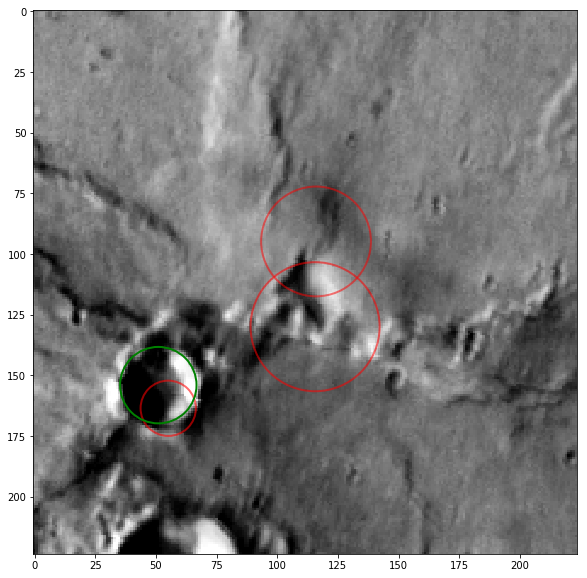

In [76]:
# Draw the predicted boxes onto the image
i = 0

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(X_test[i], cmap=plt.cm.gray)

# Draw the predicted boxes in red
for conf, y, x, r in y_pred[i]:
    if conf > 0.5:
        ax.add_patch(plt.Circle(
            (x, y), r, color='red', fill=False, linewidth=2, alpha=conf))  

# Draw the ground truth boxes in green (omit the label for more clarity)
for y, x, r in y_test[i]:
    ax.add_patch(plt.Circle((x, y), r, color='green', fill=False, linewidth=2))  

In [77]:
from rampwf.score_types.detection import (AverageDetectionPrecision, 
                                          DetectionPrecision, 
                                          DetectionRecall, 
                                          SCP)

In [79]:
average_precision = AverageDetectionPrecision()
precision = DetectionPrecision()
recall = DetectionRecall()
scp = SCP(shape=(224, 224), minipatch=[56, 168, 56, 168])
scp(y_test[:n_prefix], y_pred)

0.71396393011532211

In [87]:
average_precision(y_test[:n_prefix], y_pred)

0.35963751739159838

In [82]:
precision(y_test[:n_prefix], y_pred)

0.52631578947368418

In [83]:
recall(y_test[:n_prefix], y_pred)

0.2857142857142857

Those number depend on the confidence threshold:

In [99]:
ps = []
rs = []
scps = []

for conf_threshold in np.linspace(0, 1, 50):
    ps.append(precision(
        y_test[:n_prefix], y_pred, conf_threshold=conf_threshold))
    rs.append(recall(
        y_test[:n_prefix], y_pred, conf_threshold=conf_threshold))
    scps.append(scp(
        y_test[:n_prefix], y_pred, conf_threshold=conf_threshold))
    
ps = np.array(ps)
rs = np.array(rs)
scps = np.array(scps)

Precision-recall curve:

Text(0.7,0.8,'AP = 0.36')

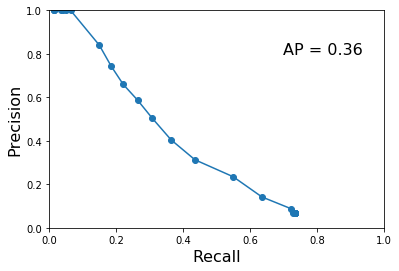

In [100]:
ap = average_precision(y_test[:n_prefix], y_pred)
fig, ax = plt.subplots()
ax.plot(rs, ps, 'o-')
ax.set_xlabel('Recall', fontsize=16)
ax.set_ylabel('Precision', fontsize=16)
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.text(0.7, 0.8, 'AP = {:.2f}'.format(ap), fontsize=16)

SCP, precision, and recall in function of the confidence threshold:

In [101]:
conf_thresholds = np.linspace(0, 1, 50)

Text(0.7,0.8,'min(SCP) = 0.69')

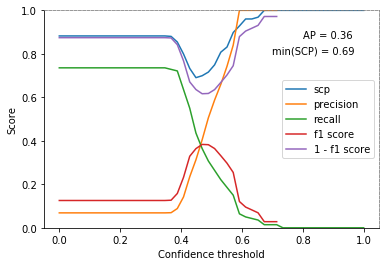

In [102]:
fig, ax = plt.subplots()
ax.plot(conf_thresholds, scps, label='scp')
ax.plot(conf_thresholds, ps, 'C1', label='precision')
ax.plot(conf_thresholds, rs, 'C2', label='recall')
ax.plot(conf_thresholds, 2*(ps * rs) / (ps + rs) , 'C3', label='f1 score')
ax.plot(conf_thresholds, 1 - 2*(ps * rs) / (ps + rs) , 'C4', label='1 - f1 score')

ax.legend(loc=7)

ax.set_xlabel("Confidence threshold")
ax.set_ylabel("Score")

ax.set_ylim(0, 1)

#ax.axhline(1, linestyle='--', color='grey')
#ax.axvline(conf_thresholds[17], color='grey', linestyle='--')
ax.spines['top'].set(linestyle='--', color='grey')
ax.spines['right'].set(linestyle='--', color='grey')
    
ax.text(0.8, 0.87, 'AP = {:.2f}'.format(ap))
ax.text(0.7, 0.80, 'min(SCP) = {:.2f}'.format(np.min(scps)))

## Local testing/exploration

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

Check list

- Make sure you have installed `ramp-workflow` locally (see [above](#Installation-of-ramp-workflow))
- Make sure that the python files `object_detector.py` is in the  `submissions/your_submission` folder, and the train and test data are in [`data`](/tree/data)
- If you haven't yet, download the images by executing 
  ```
  python download_data.py
  ```

Finally, make sure the local processing goes through by running the

```
ramp_test_submission --submission your_submission
```

If you want to quickly test the that there are no obvious code errors, use the `--quick-test` keyword to only use data from the first 30 images. 

```
ramp_test_submission --submission your_submission --quick-test
```

In [103]:
!ramp_test_submission --quick-test

Testing Mars craters detection and classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
Couldn't re-order the score matrix..
	score   ap  madc  madr   ospa  ...    rec(0)  rec(0.5)  rec(0.9)    scp
	step                           ...                                     
	test   0.0   NaN   NaN  0.989  ...     0.514       0.0       0.0  0.991
	train  0.0   NaN   NaN  0.995  ...     0.647       0.0       0.0  0.995
	valid  0.0   NaN   NaN  0.991  ...     0.714       0.0       0.0  0.994
CV fold 1
Couldn't re-order the score matrix..
	score   ap  madc  madr   ospa  ...    rec(0)  rec(0.5)  rec(0.9)    scp
	step                           ...                                     
	test   0.0   NaN   NaN  0.989  ...     0.514       0.0       0.0  0.991
	train  0.0   NaN   NaN  0.994  ...     0.786       0.0       0.0  0.995
	valid  0.0   NaN   NaN  0.992  ...     0.500       0.0       0.0  0.993
CV fold 2
Couldn't re-orde

If you get to see the train and test scores, and no errors, then you can submit your model to the ramp.studio.

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio). First, if it is your first time using RAMP, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then find an open event on the particular problem, the event [mars_craters](https://www.ramp.studio/events/mars_craters_cifar) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://www.ramp.studio/events/mars_craters/sandbox) and copy-paste (or upload) [`object_detector.py`](/edit/submissions/starting_kit/object_detector.py). Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://www.ramp.studio/events/mars_craters/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](https://www.ramp.studio/events/mars_craters/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](https://www.ramp.studio/events/mars_craters/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints scores for each cross-validation fold
```
CV fold X
	score     ap   ospa    scp  prec(0)  prec(0.5)  prec(0.9)  rec(0)  rec(0.5)  rec(0.9)   madc   madr
	train  0.372  0.536  0.752    0.804      0.773      0.319   0.427     0.410     0.168  0.634  0.166
	valid  0.287  0.623  0.798    0.580      0.564      0.282   0.349     0.340     0.173  0.655  0.138
	test   0.297  0.619  0.795    0.744      0.711      0.278   0.332     0.318     0.123  0.633  0.173
```
and the mean cross-validation score at the end 
```
----------------------------
Mean CV scores
----------------------------
	score              ap            ospa             scp        ...
	train  0.368 ± 0.0184  0.555 ± 0.0205  0.762 ± 0.0138        ...
	valid  0.323 ± 0.0323  0.607 ± 0.0348  0.789 ± 0.0208        ...
	test   0.297 ± 0.0009   0.64 ± 0.0155  0.807 ± 0.0086        ...
```

The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](https://www.ramp.studio/events/mars_craters/leaderboard)) is the mean average precision AP, that is the area under the precision/recall curve. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=Mars craters notebook).